In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

In [2]:
conn = sqlite3.connect('mimic.db')

In [3]:
# her all admissions for patients older than 65
admissions = pd.read_sql('select *, (julianday(date(admittime))-julianday(date(dob)))/365.25 as age from admissions, patients where admissions.subject_id = patients.subject_id and (julianday(date(admittime))-julianday(date(dob)))/365.25 >= 65',conn)

In [4]:
admissions['los_hrs']=admissions.apply(lambda r: (time.mktime(time.strptime(r['DISCHTIME'],'%Y-%m-%d %H:%M:%S')) - 
                 time.mktime(time.strptime(r['ADMITTIME'],'%Y-%m-%d %H:%M:%S')))/3600.0, axis=1)

In [5]:
pts = admissions.iloc[:,1].unique()
trp, tsp = train_test_split(pts, train_size=0.8)
tr = admissions[admissions.iloc[:,1].isin(trp)]
ts = admissions[admissions.iloc[:,1].isin(tsp)]

# 1. Model that uses first 24 hours of data and predicts mortality any time (after 24 hours) during hospitalization. I have collected first 24 hours data of 500 patients and trained a model. The AUC obtained is 0.81. However by visualizing all the results deeply I can see that the model trained could only identify 15 patients out 64 patients who are dead.

In [6]:
dts = []
for i in tr.index[:500]:
  pt = tr.loc[i]  
  print('Patient:', pt.iloc[1])
  for t in range(0, 24, 1):
    #print('Current time: ', t)
    labs = pd.read_sql("select * from labevents where hadm_id = \"" + pt[2] + 
                       "\" and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 >= " + str( 0) +
                       " and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 < " + str( t ), conn)
    #print('   found labs: ',len(labs.index))
    if len(labs.index) > 0:
        # output
        dead_24 = 0
        flag = 0
        if ((pt['HOSPITAL_EXPIRE_FLAG'] == '1') 
            # check if died in the hospital
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_year <= (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_year)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mon <= (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mon)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mday <= (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mday)
           ):
            flag = 1
            #print('yes')
               
        labs=labs.replace("",np.nan)
        labs['vn'] = labs.apply(lambda r: float(r['VALUENUM']),axis=1)
        gr = labs.groupby('ITEMID')
        #print(pd.DataFrame(gr['vn'].mean()).T)
        d = pd.DataFrame(gr['vn'].mean()).T
        d['class'] = flag
        d['subject_id'] = pt.iloc[1]
        d['hadm_id'] = pt.iloc[2]
        d['t'] = t
        d['dead_24'] = dead_24
        dts.append(d)
print('concatenating data')
dt_train = pd.concat(dts, ignore_index=True) 
del dts

Patient: 255
Patient: 256
Patient: 256
Patient: 256
Patient: 256
Patient: 257
Patient: 266
Patient: 268
Patient: 270
Patient: 664
Patient: 665
Patient: 665
Patient: 667
Patient: 668
Patient: 670
Patient: 674
Patient: 674
Patient: 679
Patient: 679
Patient: 680
Patient: 682
Patient: 688
Patient: 695
Patient: 695
Patient: 698
Patient: 698
Patient: 700
Patient: 703
Patient: 703
Patient: 704
Patient: 705
Patient: 707
Patient: 708
Patient: 709
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 712
Patient: 716
Patient: 717
Patient: 719
Patient: 723
Patient: 726
Patient: 728
Patient: 728
Patient: 731
Patient: 731
Patient: 733
Patient: 740
Patient: 743
Patient: 744
Patient: 746
Patient: 747
Patient: 747
Patient: 749
Patient: 752
Patient: 754
Patient: 756
Patient: 765
Patient: 767
Patient: 770
Patient: 771
Patient: 771
Patient: 772
Patient: 774
Patient: 780
Patient: 782
Patient: 782
Patient: 784
Patient: 786
Patient: 791
Patient: 792
Patient: 793
Patient: 796
Patient: 796

In [7]:
dt_train

,50868,50882,50902,50912,50931,50971,50983,51006,51146,51200,...,51429,50927,50986,50836,50842,50843,50849,51114,51115,51434
0,10.0,30.0,98.0,1.0,104.000000,4.20,134.0,20.0,1.1,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,30.0,98.0,1.0,104.000000,4.20,134.0,20.0,1.1,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,30.0,98.0,1.0,104.000000,4.20,134.0,20.0,1.1,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.0,30.0,98.0,1.0,104.000000,4.20,134.0,20.0,1.1,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.0,30.0,98.0,1.0,104.000000,4.20,134.0,20.0,1.1,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9699,15.0,23.5,98.0,1.2,168.500000,4.30,132.0,35.0,0.1,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9700,15.0,23.5,98.0,1.2,168.500000,4.30,132.0,35.0,0.1,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9701,15.0,23.5,98.0,1.2,168.500000,4.30,132.0,35.0,0.1,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9702,15.0,23.5,98.0,1.2,168.500000,4.30,132.0,35.0,0.1,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
cls = list(dt_train.columns)

In [9]:
cls.remove('hadm_id')
cls.remove('subject_id')
cls.remove('class')

In [10]:
imp = SimpleImputer()
imp.fit(dt_train)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [11]:
st = pd.DataFrame(dt_train.columns)
st['stat'] = imp.statistics_

In [12]:
cols = list(st[st['stat'].notnull()][0])

In [13]:
dt1=pd.DataFrame(imp.transform(dt_train), columns=cols)

In [14]:
lr = LogisticRegression()
lr.fit(dt1[cols],dt1['class'])

C:\Users\saite\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
probs = lr.predict_proba(dt1[cols])[:,1]

In [16]:
dt1['probs']=probs

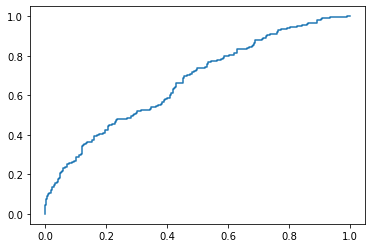

In [17]:
fpr,tpr,thresholds = roc_curve(dt1['class'],probs)
plt.plot(fpr,tpr)

In [18]:
auc(fpr,tpr)

0.6706544171760851

In [19]:
l = list(dt1[dt1['class']==1]['hadm_id'].unique())

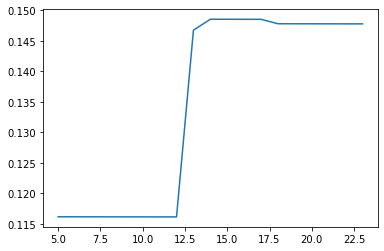

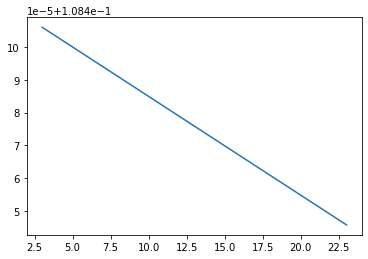

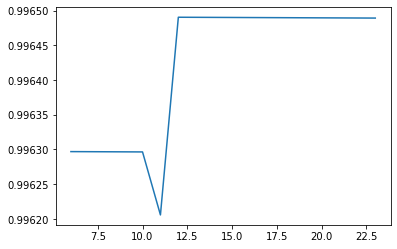

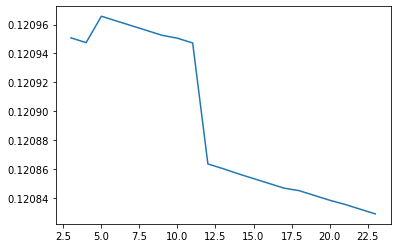

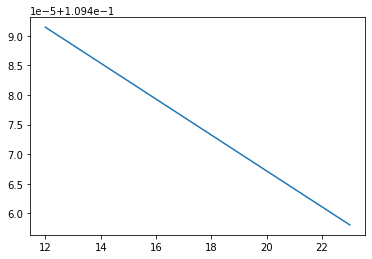

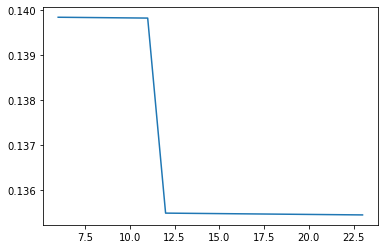

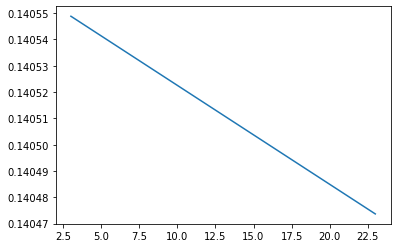

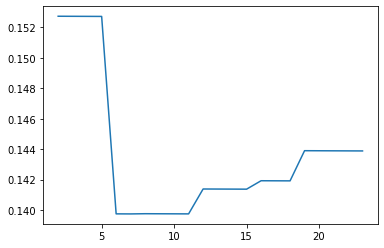

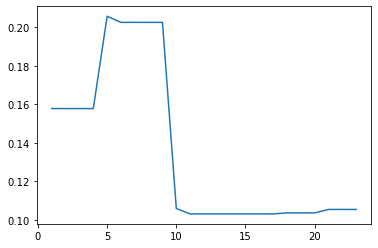

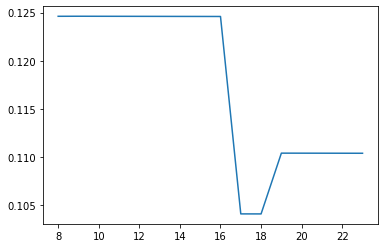

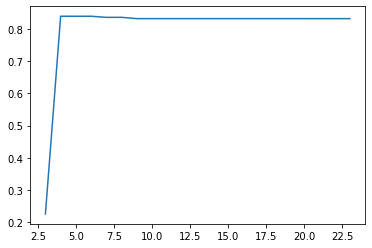

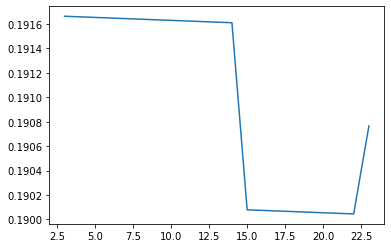

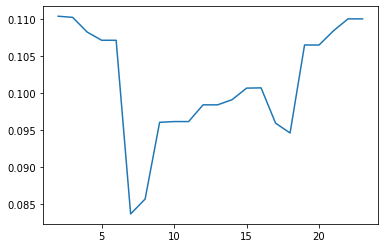

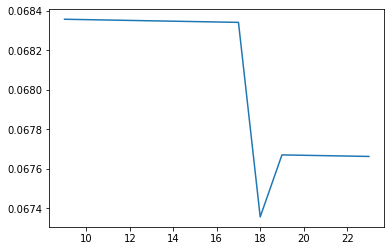

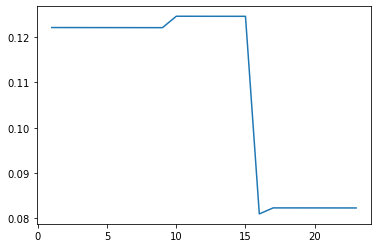

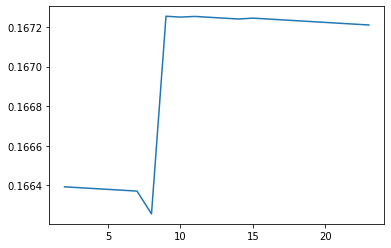

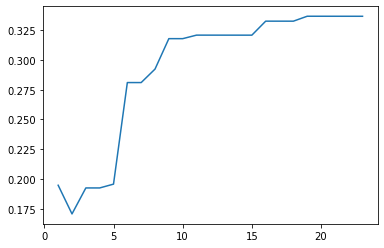

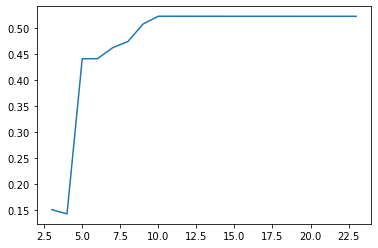

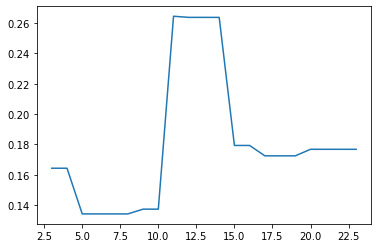

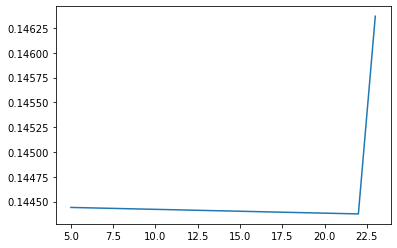

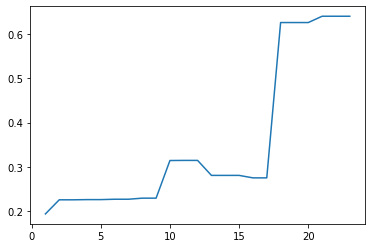

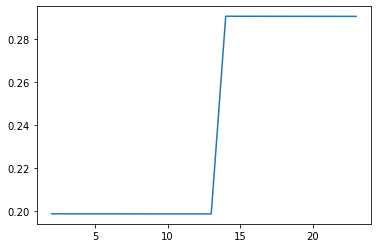

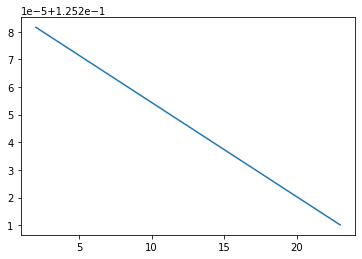

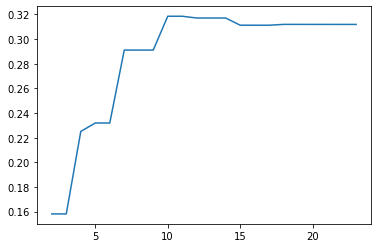

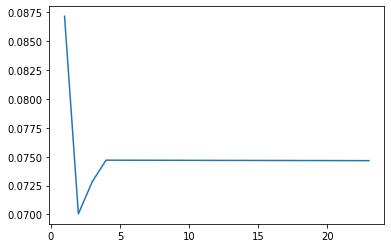

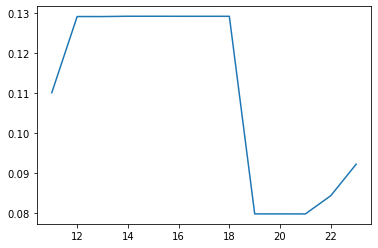

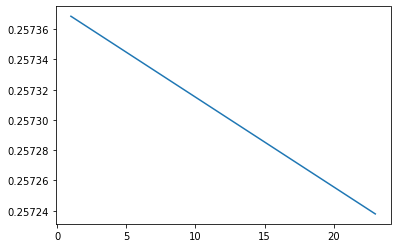

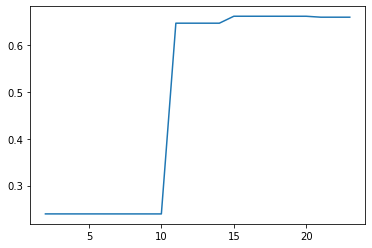

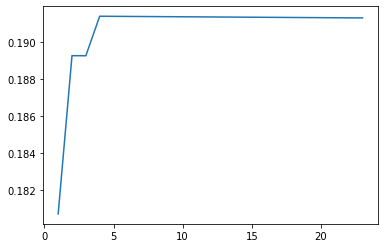

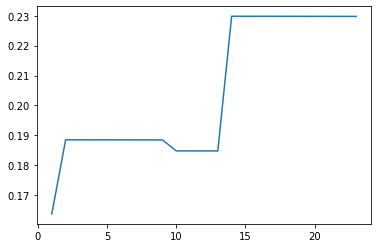

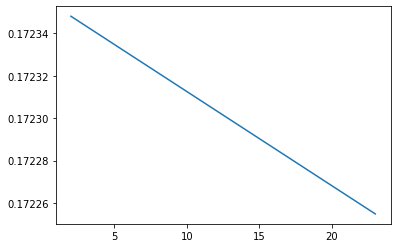

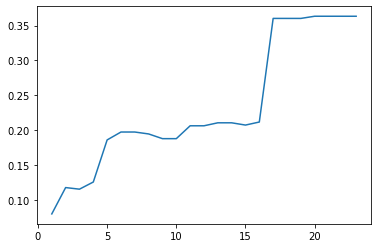

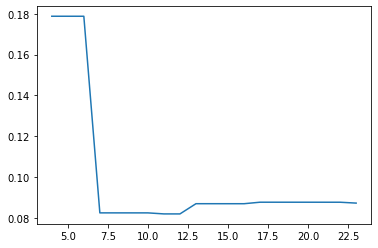

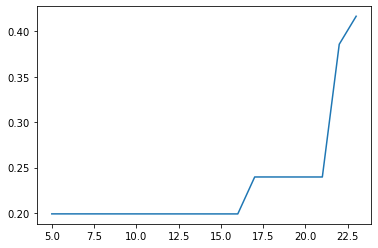

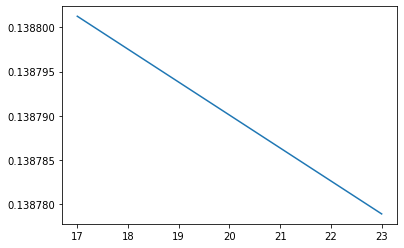

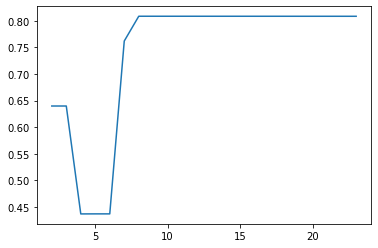

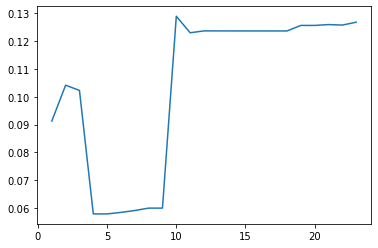

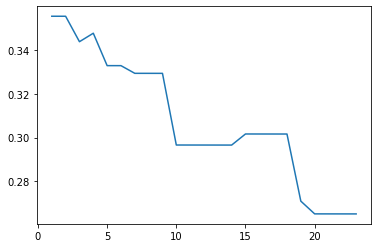

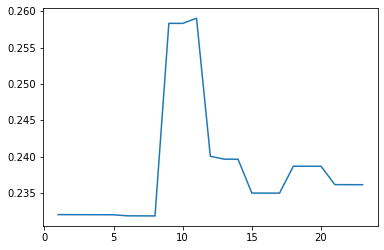

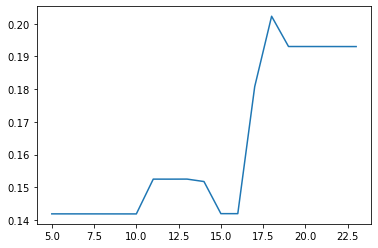

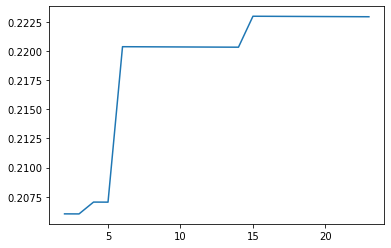

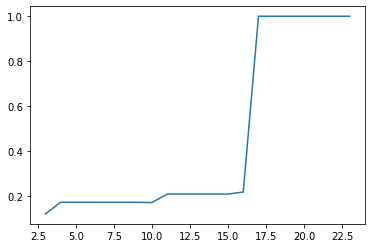

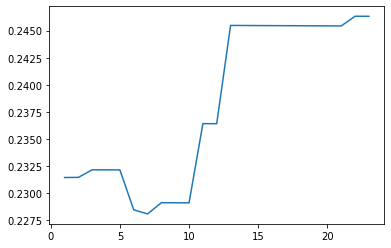

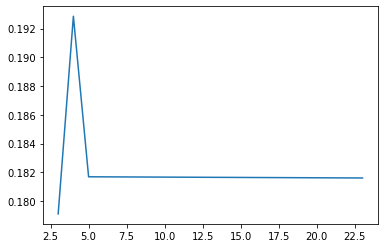

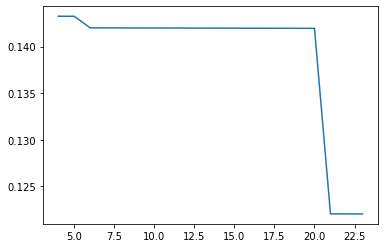

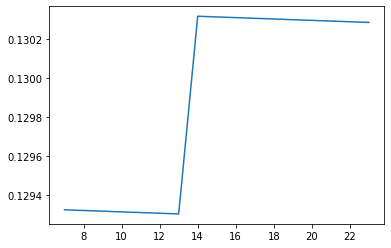

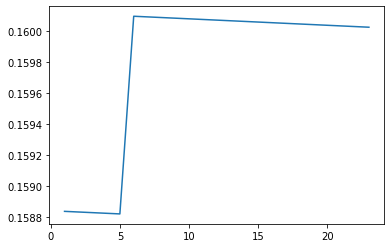

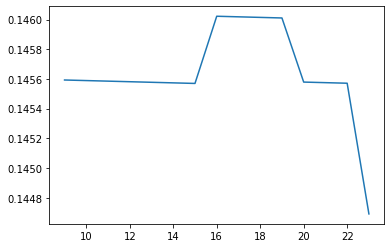

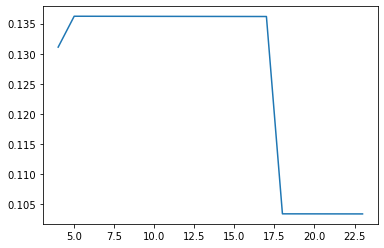

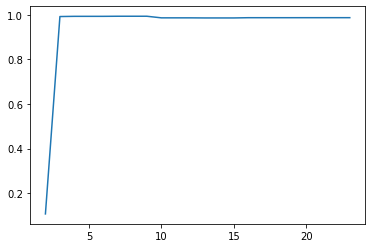

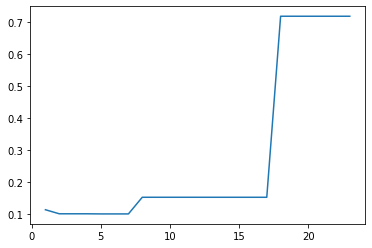

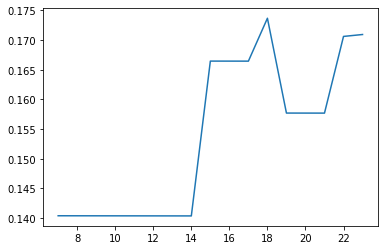

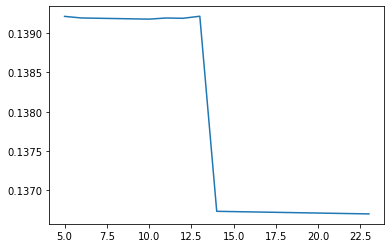

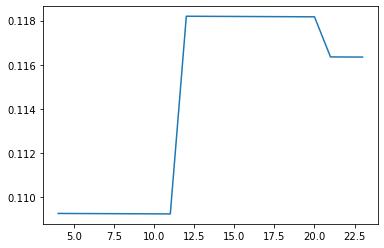

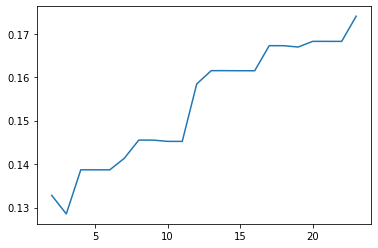

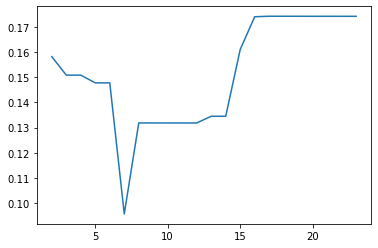

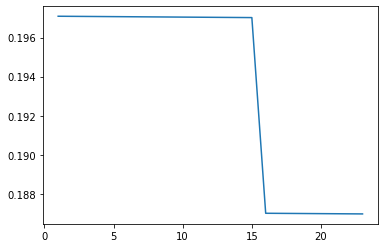

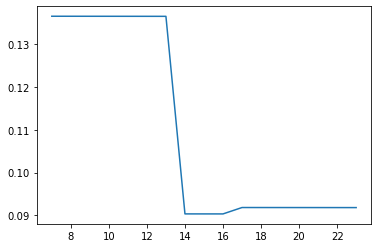

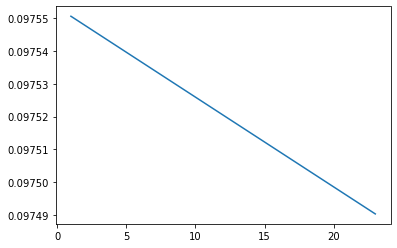

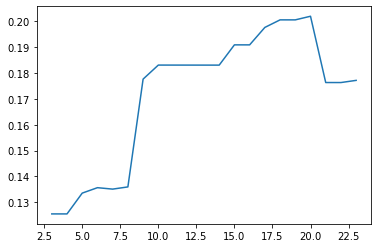

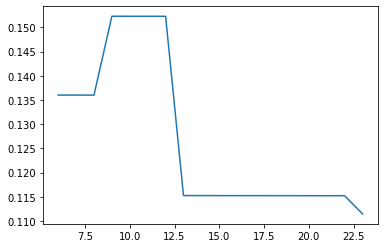

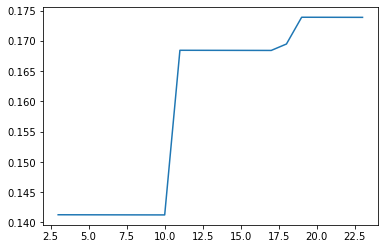

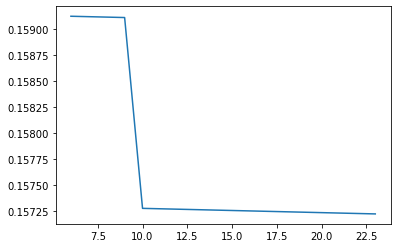

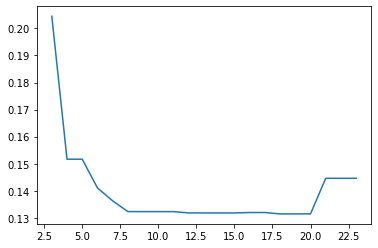

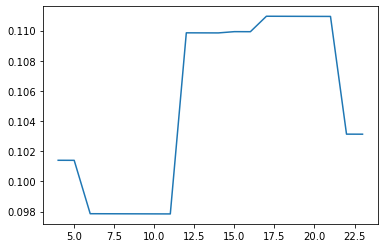

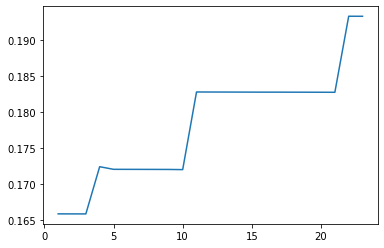

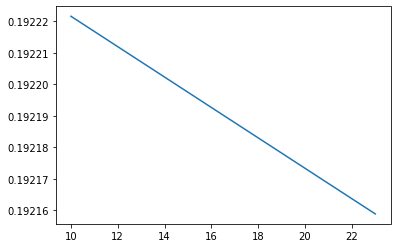

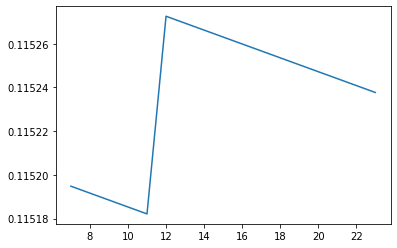

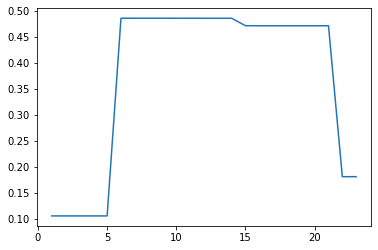

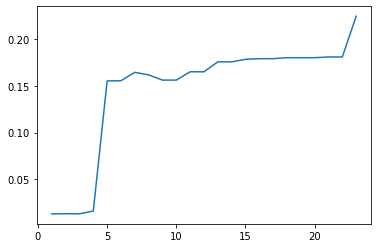

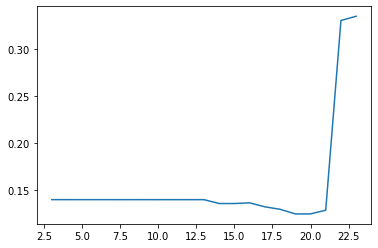

In [20]:
for a in l:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()

In [21]:
patient_dead_in_hosp = pd.DataFrame()
maxvalue = []
patients = []
flags = []
for patient in l:
    dt1_sel = dt1[dt1['hadm_id']==patient]
    flag = 0
    if dt1_sel['probs'].max() >= 0.5:
        flag = 1
    patients.append(patient)
    maxvalue.append(dt1_sel['probs'].max())
    flags.append(flag)
        

In [22]:
patient_dead_in_hosp['patients'] = patients
patient_dead_in_hosp['high_probs'] = maxvalue
patient_dead_in_hosp['flags'] = flags

In [23]:
patient_dead_in_hosp

,patients,high_probs,flags
0,110404.0,0.148536,0
1,110573.0,0.108506,0
2,113494.0,0.996490,1
3,180826.0,0.120966,0
4,148109.0,0.109491,0
...,...,...,...
66,152912.0,0.192222,0
67,163859.0,0.115273,0
68,140032.0,0.485982,0
69,157981.0,0.224622,0


In [24]:
patient_dead_in_hosp[patient_dead_in_hosp['flags']==1]

,patients,high_probs,flags
2,113494.0,0.996490,1
10,152051.0,0.840184,1
17,155897.0,0.522477,1
20,168006.0,0.640798,1
27,194340.0,0.661829,1
35,110233.0,0.808633,1
41,138066.0,1.000000,1
49,107822.0,0.993561,1
50,138230.0,0.717459,1


# 2. Model that uses 24-hour sliding window to predict morality at any time during hospitalization. 

In [25]:
window_forward = 24
window_width = 24
window_back = 24
shift = 1
window_size = 24
dts = []
for i in tr.index[:100]:
  pt = tr.loc[i]  
  print('Patient:', pt.iloc[1])
  for t in range(window_back, int(pt['los_hrs'])-window_forward, shift):
    #print('Current time: ', t)
    labs = pd.read_sql("select * from labevents where hadm_id = \"" + pt[2] + 
                       "\" and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 >= " + str( 0) +
                       " and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 < " + str( t ), conn)
    #print('   found labs: ',len(labs.index))
    if len(labs.index) > 0:
        # output
        flag = 0
        if ((pt['HOSPITAL_EXPIRE_FLAG'] == '1') 
            # check if died on the day of discharge
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_year == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_year)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mon == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mon)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mday == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mday)
            # check if died on in window
            and (time.mktime(time.strptime(pt['ADMITTIME'],'%Y-%m-%d %H:%M:%S')) + (t + window_width) * 3600 >
                 time.mktime(time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')) )
           ):
            flag = 1
            #print('yes')      
        labs=labs.replace("",np.nan)
        labs['vn'] = labs.apply(lambda r: float(r['VALUENUM']),axis=1)
        gr = labs.groupby('ITEMID')
        #print(pd.DataFrame(gr['vn'].mean()).T)
        d = pd.DataFrame(gr['vn'].mean()).T
        d['class'] = flag
        d['subject_id'] = pt.iloc[1]
        d['hadm_id'] = pt.iloc[2]
        d['t'] = t
        dts.append(d)
print('concatenating data')
patients_sliding = pd.concat(dts, ignore_index=True) 
del dts

Patient: 255
Patient: 256
Patient: 256
Patient: 256
Patient: 256
Patient: 257
Patient: 266
Patient: 268
Patient: 270
Patient: 664
Patient: 665
Patient: 665
Patient: 667
Patient: 668
Patient: 670
Patient: 674
Patient: 674
Patient: 679
Patient: 679
Patient: 680
Patient: 682
Patient: 688
Patient: 695
Patient: 695
Patient: 698
Patient: 698
Patient: 700
Patient: 703
Patient: 703
Patient: 704
Patient: 705
Patient: 707
Patient: 708
Patient: 709
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 712
Patient: 716
Patient: 717
Patient: 719
Patient: 723
Patient: 726
Patient: 728
Patient: 728
Patient: 731
Patient: 731
Patient: 733
Patient: 740
Patient: 743
Patient: 744
Patient: 746
Patient: 747
Patient: 747
Patient: 749
Patient: 752
Patient: 754
Patient: 756
Patient: 765
Patient: 767
Patient: 770
Patient: 771
Patient: 771
Patient: 772
Patient: 774
Patient: 780
Patient: 782
Patient: 782
Patient: 784
Patient: 786
Patient: 791
Patient: 792
Patient: 793
Patient: 796
Patient: 796

In [26]:
patients_sliding

,50868,50882,50893,50902,50912,50931,50960,50970,50971,50983,...,50836,50890,50891,50835,51229,51494,50968,50969,50986,51115
0,11.333333,28.333333,7.900,99.000,0.90000,144.0,1.650000,3.500000,3.933333,134.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11.333333,28.333333,7.900,99.000,0.90000,144.0,1.650000,3.500000,3.933333,134.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.333333,28.333333,7.900,99.000,0.90000,144.0,1.650000,3.500000,3.933333,134.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11.333333,28.333333,7.900,99.000,0.90000,144.0,1.650000,3.500000,3.933333,134.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11.333333,28.333333,7.900,99.000,0.90000,144.0,1.650000,3.500000,3.933333,134.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21180,16.625000,17.750000,7.625,105.125,3.91875,120.0,2.458333,4.630769,4.943750,134.562500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.228571,60.0
21181,16.625000,17.750000,7.625,105.125,3.91875,120.0,2.458333,4.630769,4.943750,134.562500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.228571,60.0
21182,16.625000,17.750000,7.625,105.125,3.91875,120.0,2.458333,4.630769,4.943750,134.562500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.228571,60.0
21183,16.625000,17.750000,7.625,105.125,3.91875,120.0,2.458333,4.630769,4.943750,134.562500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.228571,60.0


In [27]:
cls = list(patients_sliding.columns)

In [28]:
cls.remove('hadm_id')
cls.remove('subject_id')
cls.remove('class')

In [29]:
imp = SimpleImputer()
imp.fit(patients_sliding)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [30]:
st = pd.DataFrame(patients_sliding.columns)
st['stat'] = imp.statistics_

In [31]:
cols = list(st[st['stat'].notnull()][0])

In [32]:
dt1=pd.DataFrame(imp.transform(patients_sliding), columns=cols)

In [33]:
lr = LogisticRegression()
lr.fit(dt1[cols],dt1['class'])

C:\Users\saite\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
probs = lr.predict_proba(dt1[cols])[:,1]

In [35]:
dt1['probs']=probs

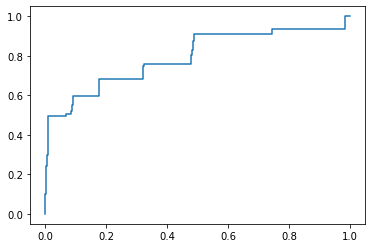

In [36]:
fpr,tpr,thresholds = roc_curve(dt1['class'],probs)
plt.plot(fpr,tpr)

In [37]:
auc(fpr,tpr)

0.7941714610121177

In [38]:
l = list(dt1[dt1['class']==1]['hadm_id'].unique())

In [39]:
patient_dead_in_hosp = pd.DataFrame()
maxvalue = []
patients = []
flags = []
for patient in l:
    dt1_sel = dt1[dt1['hadm_id']==patient]
    flag = 0
    if dt1_sel['probs'].max() >= 0.5:
        flag = 1
    patients.append(patient)
    maxvalue.append(dt1_sel['probs'].max())
    flags.append(flag)

In [40]:
patient_dead_in_hosp['patients'] = patients
patient_dead_in_hosp['high_probs'] = maxvalue
patient_dead_in_hosp['flags'] = flags

In [41]:
patient_dead_in_hosp

,patients,high_probs,flags
0,110404.0,0.002307,0
1,110573.0,0.080817,0
2,113494.0,0.404441,0
3,180826.0,0.216090,0
4,148109.0,0.030815,0
5,133099.0,0.004531,0
6,144758.0,0.003626,0
7,138064.0,0.006984,0
8,152051.0,0.000614,0
9,181423.0,0.003134,0


In [42]:
patient_dead_in_hosp[patient_dead_in_hosp['flags']==1]

,patients,high_probs,flags


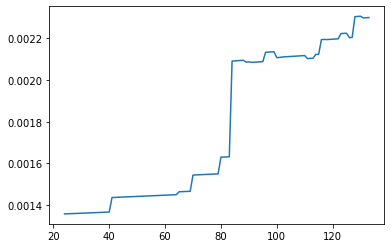

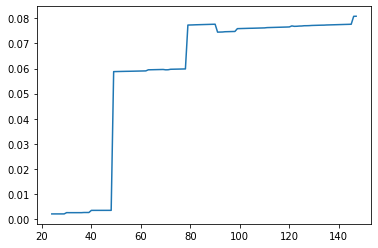

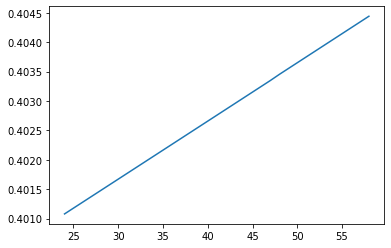

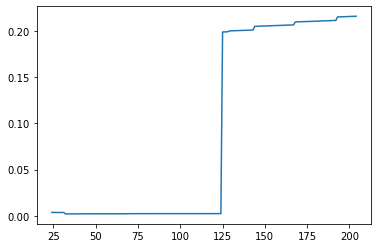

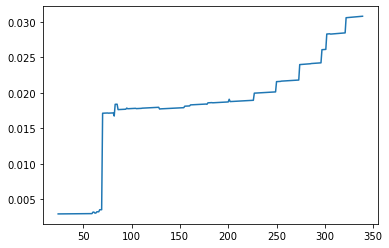

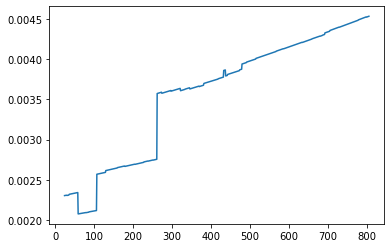

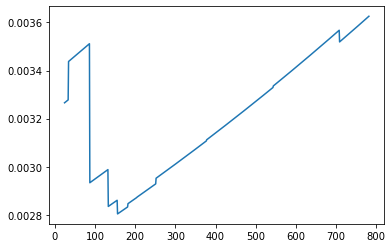

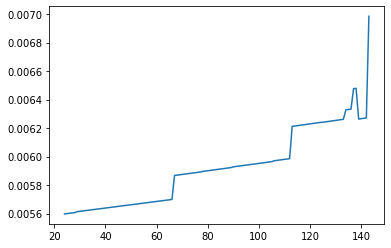

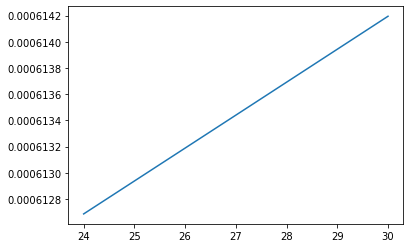

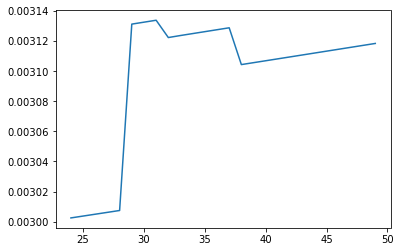

In [43]:
list_hosp = patient_dead_in_hosp['patients']
for a in list_hosp:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()

In [44]:
l_notdead = list(dt1[dt1['class']==0]['hadm_id'].unique())

In [45]:
patient_notdead_in_hosp = pd.DataFrame()
maxvalue = []
patients = []
flags = []
for patient in l:
    dt1_sel = dt1[dt1['hadm_id']==patient]
    flag = 0
    if dt1_sel['probs'].max() >= 0.5:
        flag = 1
    patients.append(patient)
    maxvalue.append(dt1_sel['probs'].max())
    flags.append(flag)

In [46]:
patient_notdead_in_hosp['patients'] = patients
patient_notdead_in_hosp['high_probs'] = maxvalue
patient_notdead_in_hosp['flags'] = flags

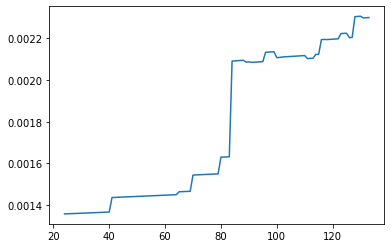

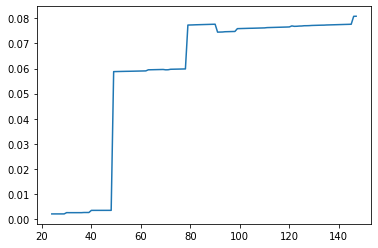

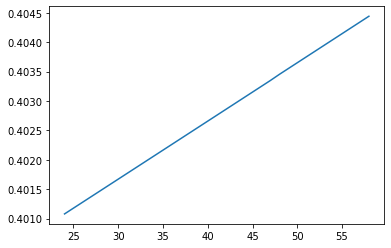

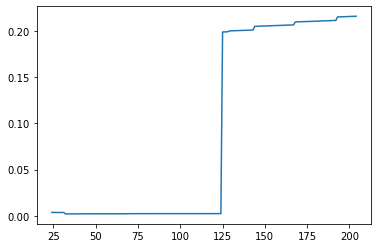

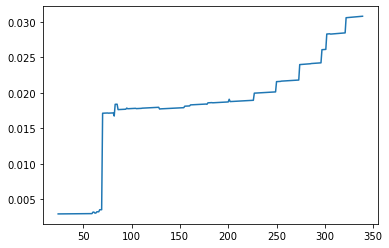

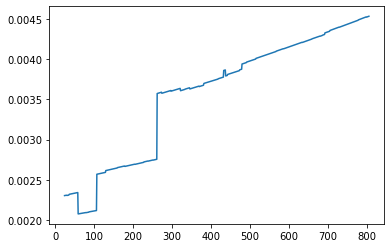

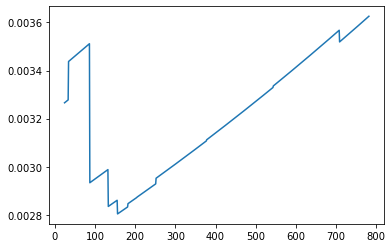

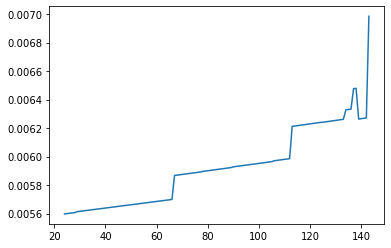

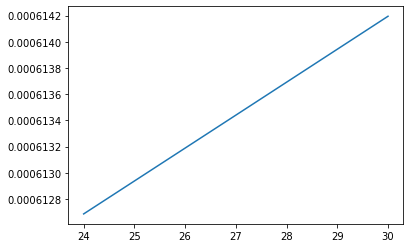

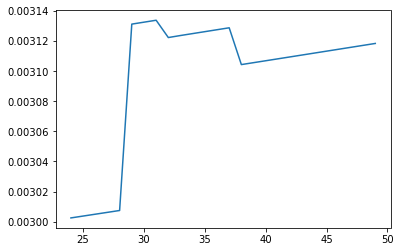

In [47]:
list_hosp = patient_notdead_in_hosp['patients']
for a in list_hosp[:10]:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()

# 3. Model that predicts mortality within 24 hours at any arbitrary point. 

In [48]:
dts = []
for i in tr.index[:500]:
  pt = tr.loc[i]  
  print('Patient:', pt.iloc[1])
  pt_los = int(pt.iloc[-1])
  for t in range(pt_los, (pt_los-24), -1):
    #print('Current time: ', t)
    labs = pd.read_sql("select * from labevents where hadm_id = \"" + pt[2] + 
                       "\" and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 >= " + str(pt_los - 24 ) +
                       " and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 < " + str( pt_los ), conn)
    #print('   found labs: ',len(labs.index))
    if len(labs.index)>0 and t >0:
        # output
        dead_24 = 0
        flag = 0
        if ((pt['HOSPITAL_EXPIRE_FLAG'] == '1') 
            # check if died in the hospital
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_year == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_year)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mon == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mon)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mday == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mday)
            and ((time.mktime(time.strptime(pt['ADMITTIME'],'%Y-%m-%d %H:%M:%S')) + (t) * 3600 >
                 time.mktime(time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S'))))
           ):
            flag = 1
            #print('yes')
               
        labs=labs.replace("",np.nan)
        labs['vn'] = labs.apply(lambda r: float(r['VALUENUM']),axis=1)
        gr = labs.groupby('ITEMID')
        #print(pd.DataFrame(gr['vn'].mean()).T)
        d = pd.DataFrame(gr['vn'].mean()).T
        d['class'] = flag
        d['subject_id'] = pt.iloc[1]
        d['hadm_id'] = pt.iloc[2]
        d['t'] = t
        d['dead_24'] = dead_24
        dts.append(d)
print('concatenating data')
dt_train = pd.concat(dts, ignore_index=True) 
del dts

Patient: 255
Patient: 256
Patient: 256
Patient: 256
Patient: 256
Patient: 257
Patient: 266
Patient: 268
Patient: 270
Patient: 664
Patient: 665
Patient: 665
Patient: 667
Patient: 668
Patient: 670
Patient: 674
Patient: 674
Patient: 679
Patient: 679
Patient: 680
Patient: 682
Patient: 688
Patient: 695
Patient: 695
Patient: 698
Patient: 698
Patient: 700
Patient: 703
Patient: 703
Patient: 704
Patient: 705
Patient: 707
Patient: 708
Patient: 709
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 712
Patient: 716
Patient: 717
Patient: 719
Patient: 723
Patient: 726
Patient: 728
Patient: 728
Patient: 731
Patient: 731
Patient: 733
Patient: 740
Patient: 743
Patient: 744
Patient: 746
Patient: 747
Patient: 747
Patient: 749
Patient: 752
Patient: 754
Patient: 756
Patient: 765
Patient: 767
Patient: 770
Patient: 771
Patient: 771
Patient: 772
Patient: 774
Patient: 780
Patient: 782
Patient: 782
Patient: 784
Patient: 786
Patient: 791
Patient: 792
Patient: 793
Patient: 796
Patient: 796

In [49]:
dt_train

,51221,class,subject_id,hadm_id,t,dead_24,50868,50882,50902,50912,...,51078,51097,51292,51479,51499,50906,50962,50972,50968,50969
0,29.8,0,255,112013,72,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29.8,0,255,112013,71,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29.8,0,255,112013,70,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29.8,0,255,112013,69,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29.8,0,255,112013,68,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8785,35.0,0,2219,116784,106,0,14.0,25.0,100.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8786,35.0,0,2219,116784,105,0,14.0,25.0,100.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8787,35.0,0,2219,116784,104,0,14.0,25.0,100.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8788,35.0,0,2219,116784,103,0,14.0,25.0,100.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
cls = list(dt_train.columns)

In [51]:
cls.remove('hadm_id')
cls.remove('subject_id')
cls.remove('class')

In [52]:
imp = SimpleImputer()
imp.fit(dt_train)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [53]:
st = pd.DataFrame(dt_train.columns)
st['stat'] = imp.statistics_

In [54]:
cols = list(st[st['stat'].notnull()][0])

In [55]:
dt1=pd.DataFrame(imp.transform(dt_train), columns=cols)

In [56]:
lr = LogisticRegression()
lr.fit(dt1[cols],dt1['class'])

C:\Users\saite\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
probs = lr.predict_proba(dt1[cols])[:,1]

In [58]:
dt1['probs'] = probs

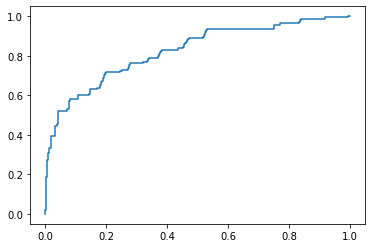

In [59]:
fpr,tpr,thresholds = roc_curve(dt1['class'],probs)
plt.plot(fpr,tpr)

In [60]:
auc(fpr,tpr)

0.8252000677996658

In [61]:
l = list(dt1[dt1['class']==1]['hadm_id'].unique())

In [62]:
patient_dead_in_hosp = pd.DataFrame()
maxvalue = []
patients = []
flags = []
for patient in l:
    dt1_sel = dt1[dt1['hadm_id']==patient]
    flag = 0
    if dt1_sel['probs'].max() >= 0.5:
        flag = 1
    patients.append(patient)
    maxvalue.append(dt1_sel['probs'].max())
    flags.append(flag)

In [63]:
patient_dead_in_hosp['patients'] = patients
patient_dead_in_hosp['high_probs'] = maxvalue
patient_dead_in_hosp['flags'] = flags

In [64]:
x = patient_dead_in_hosp[patient_dead_in_hosp['flags']==1]
x.shape

(7, 3)

In [65]:
patient_dead_in_hosp.shape

(42, 3)

In [66]:
patient_dead_in_hosp = pd.DataFrame()
maxvalue = []
patients = []
flags = []
for patient in l:
    dt1_sel = dt1[dt1['hadm_id']==patient]
    flag = 0
    if dt1_sel['probs'].max() >= 0.5:
        flag = 1
    patients.append(patient)
    maxvalue.append(dt1_sel['probs'].max())
    flags.append(flag)

In [67]:
patient_dead_in_hosp['patients'] = patients
patient_dead_in_hosp['high_probs'] = maxvalue
patient_dead_in_hosp['flags'] = flags

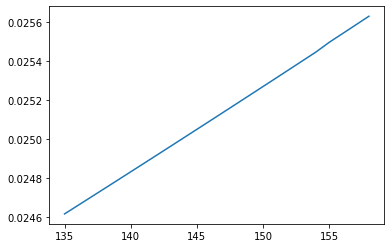

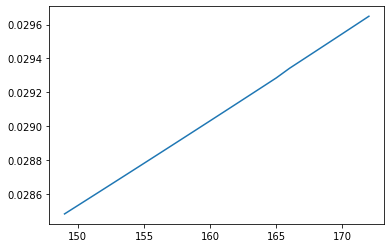

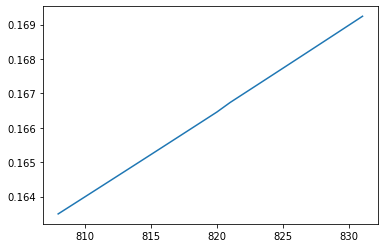

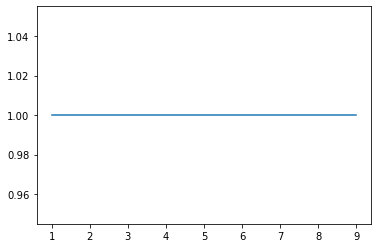

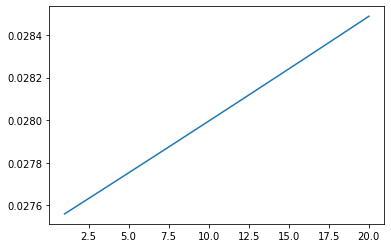

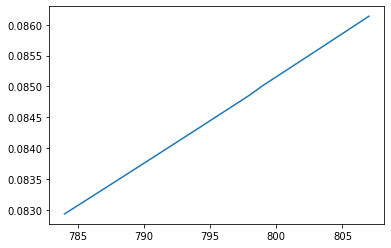

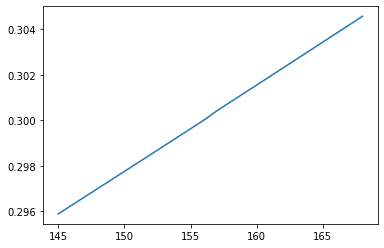

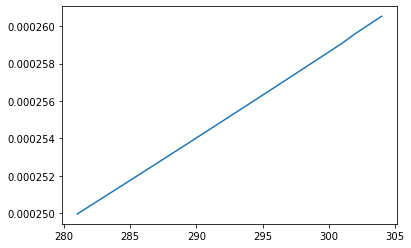

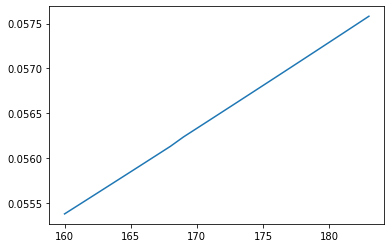

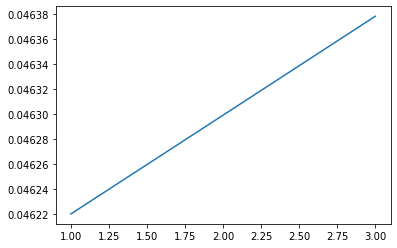

In [68]:
list_hosp = patient_dead_in_hosp['patients']
for a in list_hosp[:10]:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()

In [69]:
l_notdead = list(dt1[dt1['class']==0]['hadm_id'].unique())

In [70]:
patient_notdead_in_hosp = pd.DataFrame()
maxvalue = []
patients = []
flags = []
for patient in l_notdead:
    dt1_sel = dt1[dt1['hadm_id']==patient]
    flag = 0
    if dt1_sel['probs'].max() >= 0.5:
        flag = 1
    patients.append(patient)
    maxvalue.append(dt1_sel['probs'].max())
    flags.append(flag)

In [71]:
patient_notdead_in_hosp['patients'] = patients
patient_notdead_in_hosp['high_probs'] = maxvalue
patient_notdead_in_hosp['flags'] = flags

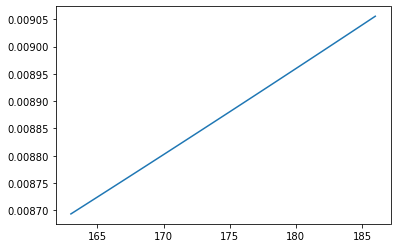

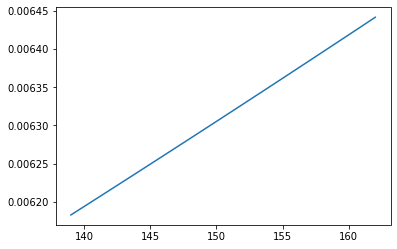

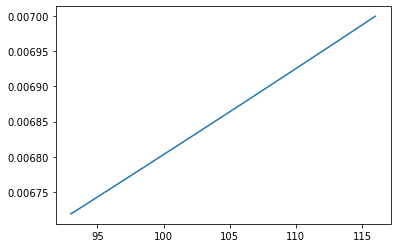

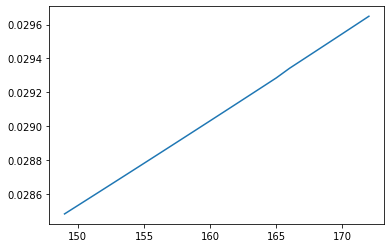

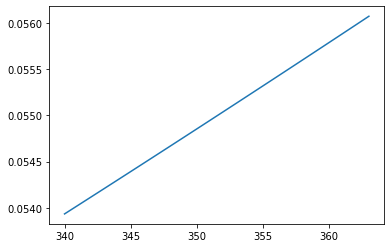

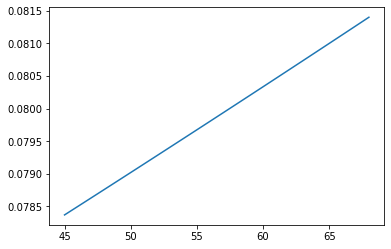

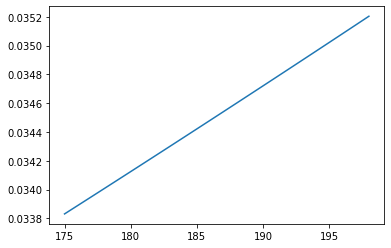

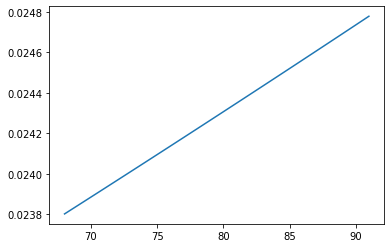

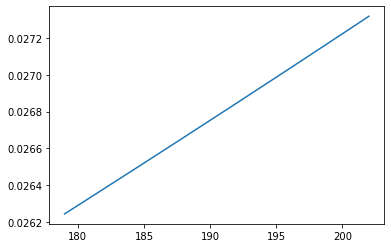

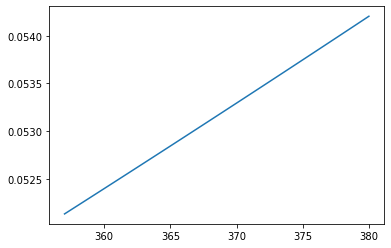

In [72]:
list_hosp = patient_notdead_in_hosp['patients']
for a in list_hosp[10:20]:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()